In [1]:
import time
import re, ast
import numpy as np
from math import pow
import os
from IPython.display import clear_output
import findspark
import pandas as pd
findspark.init()
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession,SQLContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.mllib.regression import StreamingLinearRegressionWithSGD
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLReceive") \
    .getOrCreate()

In [3]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='ml',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "zoo1:2181,zoo2:2181,zoo3:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]

In [4]:
def trainInitialModel():
    global features
    dfs = []
    df = pd.read_csv('../../data/2017-02-28_all.csv',dtype={"measurement": float})
    df.sort_values('time', inplace=True)
    dataDict = dict()
    for i in df['sensorid'].unique():
        dataDict[i] = []
    sensors = list(dataDict.keys())
    relevantSensors = dict()
    relevantSensors['1-0'] = sensors[:]
    relevantSensors['24-0'] = sensors[:]
    for r in [1,22,24,25]:
        relevantSensors['1-0'].remove('{0}-0'.format(r))
    for r in [1,2,3,24,33,35]:
        relevantSensors['24-0'].remove('{0}-0'.format(r))

    ready = False
    i = 0
    rows = df.values.tolist()

    while not ready:
        dataDict[rows[i][2]].append(rows[i][3])
        ready = True
        for sens in relevantSensors:
            for s in relevantSensors[sens]:
                if len(dataDict[s])<features:
                    ready = False
                    break
        i+=1

    X_train = dict()
    Y_train = dict()
    for k in relevantSensors:
        X_train[k] = []
        Y_train[k] = []
        for s in relevantSensors[k]:
            dataDict[s]  =dataDict[s][-features:]
            
    if rows[i-1][2] in relevantSensors:
        x = []
        for s in relevantSensors[rows[i-1][2]]:
            x.append(dataDict[s])
        X_train[rows[i-1][2]].extend(x)
        Y_train[rows[i-1][2]].append(rows[i-1][3])
        
    while i<len(rows):
        if rows[i][2] in relevantSensors:
            x = []
#             print(rows[i][2])
#             print(relevantSensors[rows[i][2]])
            for s in relevantSensors[rows[i][2]]:
                x.extend(dataDict[s])
            X_train[rows[i][2]].append(x)
            Y_train[rows[i][2]].append(rows[i][3])
        else:
            dataDict[rows[i][2]] = dataDict[rows[i][2]][1:]
            dataDict[rows[i][2]].append(rows[i][3])
        i+=1
    models = dict()
    for s in relevantSensors:
        clf = MLPRegressor()
        clf.fit(X_train[s],Y_train[s])
        models[s] =clf
    return models, dataDict,relevantSensors

In [5]:
def predict(data):
    global models,day,relevantSensors,dataDict
    start = time.time()
    data = data.collect()
    realValues = []
    predictedValues = []
    newX = dict()
    newY = dict()
    mses = dict() #mean squared error list
    sse = dict() # sum of squared errors
    N = dict()
    for k in relevantSensors:
        newX[k] = []
        newY[k] = []
        mses[k] = []
        sse[k] = 0
        N[k] = 0
    i=0
 
    while i<len(data):
        sensor = data[i][0]
        measurement = data[i][1][0]
        if sensor in relevantSensors:
            x = []
            for s in relevantSensors[sensor]:
                x.extend(dataDict[s])
            newX[sensor].append(x)
            newY[sensor].append(measurement)
            predy = models[sensor].predict([x])
            sse[k] += pow(predy - measurement,2)
            N[k] +=1
            mses[k].append(sse[k]/N[k])
        else:
            dataDict[sensor] = dataDict[sensor][1:]
            dataDict[sensor].append(measurement)
        i+=1
    if len(data)>0:
        for k in relevantSensors:
            pred_y = models[k].predict(newX[k])
            print('day',day,k)
            print('mse :',mean_squared_error(newY[k],pred_y),k)
            fig1,ax1 = plt.subplots()
            ax1.plot(pred_y)#,marker='.', alpha=0.5, linestyle='None')
            ax1.plot(newY[k])#,marker='.', alpha=0.5, linestyle='None')
            ax1.plot(mses[k])
            plt.title('Temperature for sensor {0} on day {1}'.format(k,day))
            ax1.legend('predicted value','actual value')
            plt.show()
            day+=1

    end = time.time()
    print('time',end-start)

In [6]:
features = 10
start = time.time()

models,dataDict,relevantSensors = trainInitialModel()
end = time.time()
print(end-start)
sc,ssc,dstream = getKafkaDStream(spark)

dstream = dstream.map(lambda x: np.array(ast.literal_eval(x[1])))
dstream=dstream.flatMap(lambda x: [(x[1],[float(x[2])])])
day = 2 
dstream.foreachRDD(predict)


0.5282878875732422


time 0.04305577278137207
day 2 1-0
mse : 1.17080267445 1-0


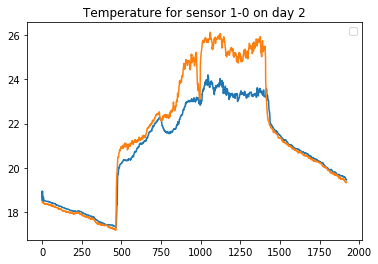

day 3 24-0
mse : 0.557972425766 24-0


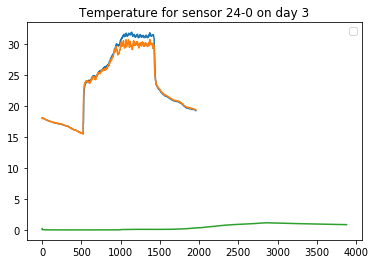

time 1.1772942543029785
day 4 1-0
mse : 0.377816512777 1-0


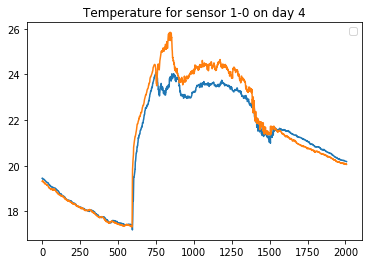

day 5 24-0
mse : 0.2005835758 24-0


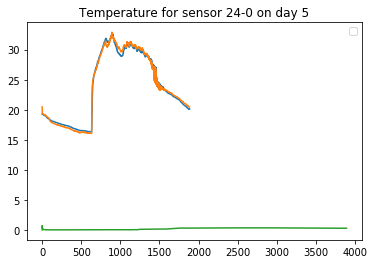

time 0.7250485420227051
day 6 1-0
mse : 0.616076607151 1-0


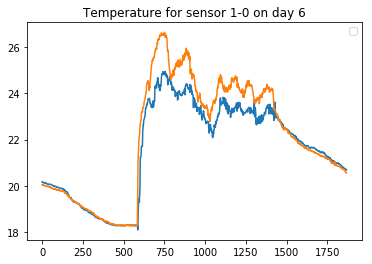

day 7 24-0
mse : 0.789555232357 24-0


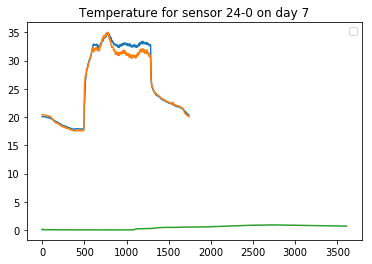

time 0.6204049587249756
day 8 1-0
mse : 0.938541018511 1-0


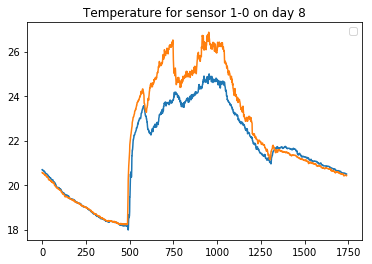

day 9 24-0
mse : 0.148678172695 24-0


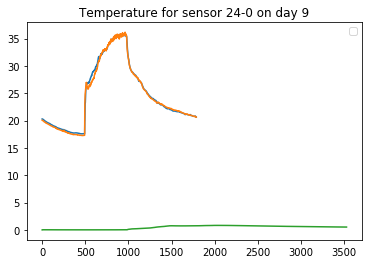

time 0.6991651058197021
day 10 1-0
mse : 0.519155686916 1-0


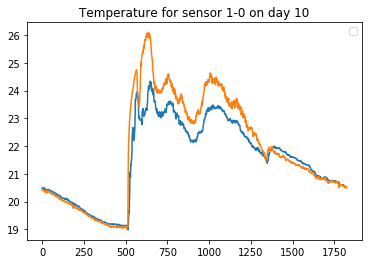

day 11 24-0
mse : 0.135104348503 24-0


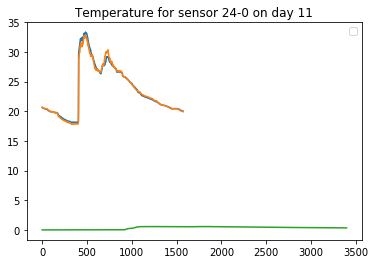

time 0.5842559337615967
day 12 1-0
mse : 0.0549813745694 1-0


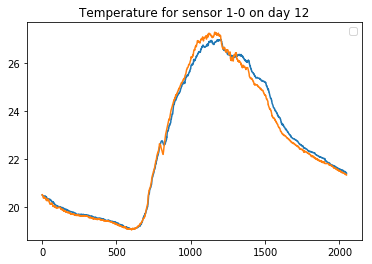

day 13 24-0
mse : 0.263379960431 24-0


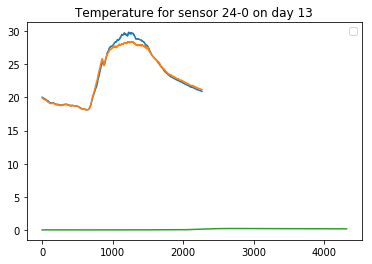

time 0.6446774005889893
day 14 1-0
mse : 0.0685532135635 1-0


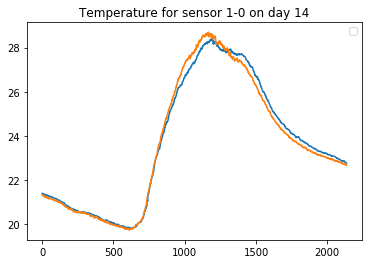

day 15 24-0
mse : 0.463774258762 24-0


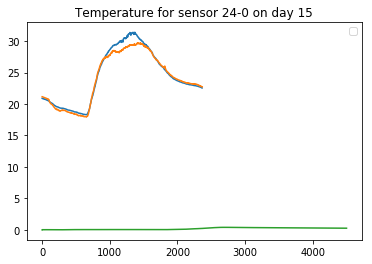

time 0.5994188785552979
time 0.009880304336547852
time 0.0065615177154541016
time 0.00817251205444336
time 0.007088661193847656
time 0.00754094123840332
time 0.006945371627807617


KeyboardInterrupt: 

time 0.009242057800292969
time 0.01281428337097168
time 0.0073394775390625
time 0.007226467132568359
time 0.006655216217041016
time 0.008487701416015625
time 0.006969928741455078
time 0.006442546844482422
time 0.0071299076080322266
time 0.005869626998901367
time 0.00848388671875
time 0.006128549575805664
time 0.006451606750488281
time 0.0060503482818603516
time 0.0068662166595458984
time 0.006321907043457031
time 0.007990598678588867
time 0.007051944732666016
time 0.0073430538177490234


In [7]:
ssc.start()
ssc.awaitTermination()